In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc
from scipy.spatial.distance import cdist

## training
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [34]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device  # Add this line
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # 1 output (odor)

    def forward(self, x):
        if x.dim() == 3:  # If a batch of sequences is passed in
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        elif x.dim() == 2:  # If a single sequence is passed in
            h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
        else:
            raise ValueError("Unexpected input dimension: %d" % x.dim())
        out, _ = self.lstm(x.unsqueeze(0) if x.dim() == 2 else x, (h0, c0))
        out = self.fc(out.squeeze(0) if x.dim() == 2 else out[:, -1, :])
        return out

    def reset_hidden_state(self, batch_size):
        self.hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device),
                       torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device))

        
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)  # Make LSTM bidirectional
        self.fc = nn.Linear(hidden_size * 2, 1)  # Adjust the input size of the fully connected layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        if x.dim() == 3:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)  # Adjust the initial hidden state
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        elif x.dim() == 2:
            h0 = torch.zeros(self.num_layers * 2, 1, self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers * 2, 1, self.hidden_size).to(self.device)
        else:
            raise ValueError("Unexpected input dimension: %d" % x.dim())

        out, _ = self.lstm(x.unsqueeze(0) if x.dim() == 2 else x, (h0, c0))
        out = self.fc(out.squeeze(0) if x.dim() == 2 else out[:, -1, :])
        return out

    def reset_hidden_state(self, batch_size):
        self.hidden = (torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(self.device),
                       torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(self.device))
        
        
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(CNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.cnn = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
#         x = x.view(batch_size * seq_length, 1, -1)
        x = x.view(batch_size, seq_length, -1).permute(0, 2, 1)

        x = self.cnn(x)
        x = x.view(batch_size, seq_length, -1)
        out, hidden = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out  # Return only the output


    def reset_hidden_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device))


In [35]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

def load_and_preprocess_file(file_path, features, target):
    # Load the data
    df = pd.read_hdf(file_path)
    # df['scaled_odor']=scale_data(df.odor)
    # Scale the features
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Convert data to PyTorch tensors
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    # Reshape to (seq_length, n_features)
    feature_tensors = feature_tensors.view(-1, len(features))

    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)


def train_on_single_file(model, optimizer, criterion, sequences, targets, num_epochs, batch_size):
    model.train()
    num_batches = len(sequences) // batch_size  # Determine the number of batches
    
    for epoch in range(num_epochs):
        for batch_idx in range(num_batches):  # Iterate over each batch
            # Get the current batch of sequences and targets
            batch_sequences = sequences[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_targets = targets[batch_idx * batch_size : (batch_idx + 1) * batch_size]

            # Reset the hidden state for each new batch
            model.reset_hidden_state(batch_size)

            # Forward pass
            outputs = model(batch_sequences.view(-1, seq_length, input_size))
            # loss = criterion(outputs[:, -1, :], batch_targets.view(-1, 1))  # Compare only the last prediction with the target
            loss = criterion(outputs[:, -1], batch_targets.view(-1, 1))  # Compare only the last prediction with the target

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 50 ==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
            
            
def whiff_mean_concentration(tensor):
    # print(torch.mean(tensor))
    return torch.mean(tensor)

## faster method but needs more gpu power
def train_on_single_file_faster(model, optimizer, criterion, sequences, targets, num_epochs):

    model.train()
    batch_size = sequences.size(0)
    for epoch in range(num_epochs):
        model.reset_hidden_state(batch_size)

        # Forward pass
        outputs = model(sequences.view(-1, seq_length, input_size))
        loss = criterion(outputs, targets.view(-1, 1))  # Compare the output directly with the target
         # Original MSE loss
        # mse_loss = criterion(outputs, targets.view(-1, 1))
        
        # # Additional 'whiff' loss
        # predicted_whiff_mean = whiff_mean_concentration(outputs)
        # actual_whiff_mean = whiff_mean_concentration(targets)
        # whiff_loss = torch.abs(predicted_whiff_mean - actual_whiff_mean)
        
        # # Combined loss
        # loss = mse_loss + whiff_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')




def predict_on_new_data(model, new_data_path, features, target, seq_length, device):
    # Load and preprocess the new data
    feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)

    # Move sequences to the device
    sequences = sequences.to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(sequences.view(-1, seq_length, len(features)))

    # Convert the predictions to a numpy array
    predictions = predictions.cpu().numpy()

    return predictions


### Initialization of the model parameters

In [37]:
features = ['distance_along_streakline','nearest_from_streakline']
# features = ['windx','windy','x','y',]
target = ['odor']
seq_length = 5  # Choose a suitable sequence length
num_epochs = 500  # Choose a suitable number of epochs

# Initialize LSTM model
input_size = 2  # Number of features
hidden_size = 128
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = LSTM(input_size, hidden_size, num_layers, device)

### Train with 1 LSTM

In [38]:
model = CNNLSTM(input_size, hidden_size, num_layers, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.009)  # Define your optimizer
criterion = nn.MSELoss()  # Define your loss function


# Iterate over files
filepath="/home/beast/An/data/Sept13Plumes/plume1/train/"
for file in os.listdir(filepath):  # Replace with the actual path
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    sequences = sequences.to(device)
    targets = targets.to(device)
    train_on_single_file_faster(model, optimizer, criterion, sequences, targets, num_epochs)

2
Epoch [100/500], Loss: 0.10673484951257706
Epoch [200/500], Loss: 0.10802329331636429
Epoch [300/500], Loss: 0.10790758579969406
Epoch [400/500], Loss: 0.107715904712677
Epoch [500/500], Loss: 0.10112722218036652
Epoch [100/500], Loss: 0.13828471302986145
Epoch [200/500], Loss: 0.1371038258075714
Epoch [300/500], Loss: 0.13188764452934265
Epoch [400/500], Loss: 0.01645485870540142
Epoch [500/500], Loss: 0.016061220318078995
Epoch [100/500], Loss: 0.33210596442222595
Epoch [200/500], Loss: 0.33958369493484497
Epoch [300/500], Loss: 0.33937889337539673
Epoch [400/500], Loss: 0.3393781781196594
Epoch [500/500], Loss: 0.3393770456314087
Epoch [100/500], Loss: 3.37718847731594e-05
Epoch [200/500], Loss: 3.358757749083452e-05
Epoch [300/500], Loss: 3.358754838700406e-05
Epoch [400/500], Loss: 3.358752292115241e-05
Epoch [500/500], Loss: 3.358749745530076e-05
Epoch [100/500], Loss: 0.14633016288280487
Epoch [200/500], Loss: 0.1463293731212616
Epoch [300/500], Loss: 0.14632436633110046
Epoch

### Train using a ensemble of models

In [5]:
# # # Create three LSTM models
# model1 = LSTM(input_size, hidden_size, num_layers, device).to(device)
# model2 = BiLSTM(input_size, hidden_size, num_layers, device).to(device)
# model3 = CNNLSTM(input_size, hidden_size, num_layers, device).to(device)

# # Create three different optimizers, one for each model
# optimizer1 = optim.Adam(model1.parameters(), lr=0.007)  
# optimizer2 = optim.Adam(model2.parameters(), lr=0.007)  
# optimizer3 = optim.Adam(model3.parameters(), lr=0.007)  

# criterion = nn.MSELoss()  # Define your loss function

# # Iterate over files
# filepath="/home/beast/An/data/train_new_axis/"
# for file in os.listdir(filepath):  # Replace with the actual path
#     file_path = os.path.join(filepath, file)
#     feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
#     sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
#     sequences = sequences.to(device)
#     targets = targets.to(device)
    
#     # Train each model on the current file
#     train_on_single_file_faster(model1, optimizer1, criterion, sequences, targets, num_epochs)
#     torch.cuda.empty_cache()
#     # train_on_single_file_faster(model2, optimizer2, criterion, sequences, targets, num_epochs)
#     # torch.cuda.empty_cache()
#     train_on_single_file_faster(model3, optimizer3, criterion, sequences, targets, num_epochs)
#     torch.cuda.empty_cache()

In [83]:
# torch.save(model.state_dict(), '../assets/models/modelLSTMSept18-500epoch_noaxis.pth')
# torch.save(model2.state_dict(), 'model2.pth')
# torch.save(model3.state_dict(), '../assets/models/modelCNNLSTMEnsembleAug2.pth')

### Prediction using one model

In [68]:
# model = LSTM(input_size, hidden_size, num_layers, device)
# model.load_state_dict(torch.load('../assets/models/modelLSTMSept18-500epoch.pth'))
# model=model.to(device)

In [43]:
# Specify the directory you're working from
folder_path = '/home/beast/An/data/Sept13Plumes/plume1/train/'

all_filenames = [filename for filename in os.listdir(folder_path) if filename.startswith("diag") and filename.endswith(".h5")]
sorted_filenames = sorted(all_filenames, key=lambda x: int(x[4:-3]))

# # Initialize an empty dataframe
all_data = pd.DataFrame()

# Loop through the files and read each one into a dataframe
for file in sorted_filenames:
    file_path = os.path.join(folder_path, file)
    df = pd.read_hdf(file_path)
    all_data = pd.concat([all_data, df])
    
all_data.reset_index(drop=True, inplace=True)
all_data.to_hdf(folder_path+'combined.h5', key='data',mode='w')

In [46]:
# all_data.to_hdf('/home/beast/An/data/Sept13Plumes/plume1/combined.h5', key='data',mode='w')

In [61]:
new_data_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag10.h5"
# new_data_path = "/home/beast/An/data/Sept13Plumes/plume1/combined.h5"
predictions = predict_on_new_data(model, new_data_path, features, target, seq_length, device)
test=pd.read_hdf(new_data_path)
test['predicted_odor']=np.pad(predictions.flatten(),(0, len(test)-len(predictions)),mode='constant')

Text(0.5, 1.0, '400ep/timeseries')

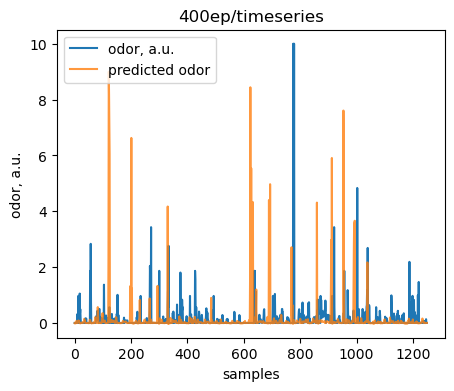

In [62]:
f,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(test.odor, label='odor, a.u.')
ax.plot(test.predicted_odor, alpha=0.8,label='predicted odor')
ax.set_ylabel('odor, a.u.')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('400ep/timeseries')
# mpl_functions.set_fontsize(f, 15)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [63]:
# test=all_data.copy()

In [64]:
# f, ax=plt.subplots(1,1)
# v = ax.scatter(test.distance_along_streakline, test.nearest_from_streakline, c=test.odor, cmap='inferno')

# ax.set_title('Odor Th > 1 a.u.')
# ax.set_ylabel('Distance from source, m')
# ax.set_xlabel('Distance along streakline, m')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')


In [65]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>0.5'
df = test.query(query)
df.reset_index(drop=True, inplace=True)

query1='predicted_odor>0.5'
df1 = test.query(query1)
df1.reset_index(drop=True, inplace=True)


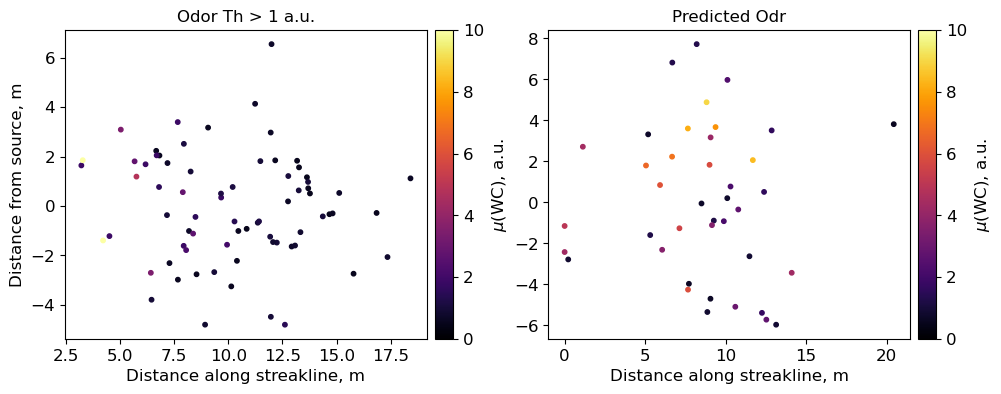

In [66]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=df.odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax1.set_title('Odor Th > 1 a.u.')
ax1.set_ylabel('Distance from source, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.predicted_odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax2.set_title('Predicted Odr')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

### Prediction using ensemble model

In [99]:
## Initializing models
model1 = LSTM(input_size, hidden_size, num_layers, device)
model2 = CNNLSTM(input_size, hidden_size, num_layers, device)

# Loading saved models
model1.load_state_dict(torch.load('../assets/models/archive/modelLSTMEnsembleAug2.pth'))
model2.load_state_dict(torch.load('../assets/models/archive/modelCNNLSTMEnsembleAug2.pth'))

# Move models to GPU
model1 = model1.to(device)
model2 = model2.to(device)


In [17]:
# To make predictions, take the average of the predictions from all models
def ensemble_predict(models, data):
    predictions = [model(data) for model in models]
    return torch.mean(torch.stack(predictions), dim=0)

# Make predictions on new data using the ensemble of models
new_data_path = "/home/beast/An/data/train_new_axis/diag40.h5"
feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
sequences = sequences.to(device)

# Use the ensemble to make predictions
predictions = ensemble_predict([model1, model2], sequences)
pred=predictions.cpu().detach().numpy()
test = pd.read_hdf(new_data_path)
test['predicted_odor']=np.pad(pred.flatten(),(0, len(test)-len(pred)),mode='constant')

Text(0.5, 1.0, '400ep/timeseries')

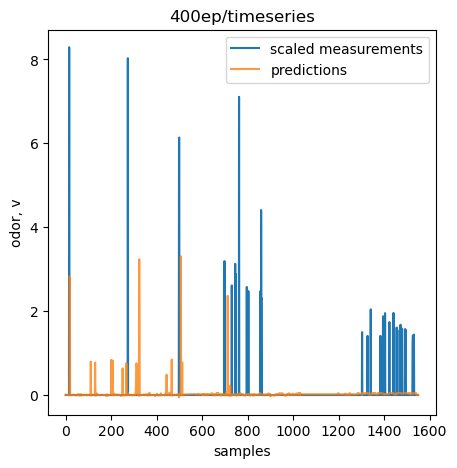

In [18]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot((test.odor), label='scaled measurements')
ax.plot(test.predicted_odor, alpha=0.8,label='predictions')
ax.set_ylabel('odor, v')
ax.set_xlabel('samples')
ax.legend()
ax.set_title('400ep/timeseries')
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [19]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>1'
df = test.query(query)
df.reset_index(drop=True, inplace=True)

query1='predicted_odor>1'
df1 = test.query(query1)
df1.reset_index(drop=True, inplace=True)


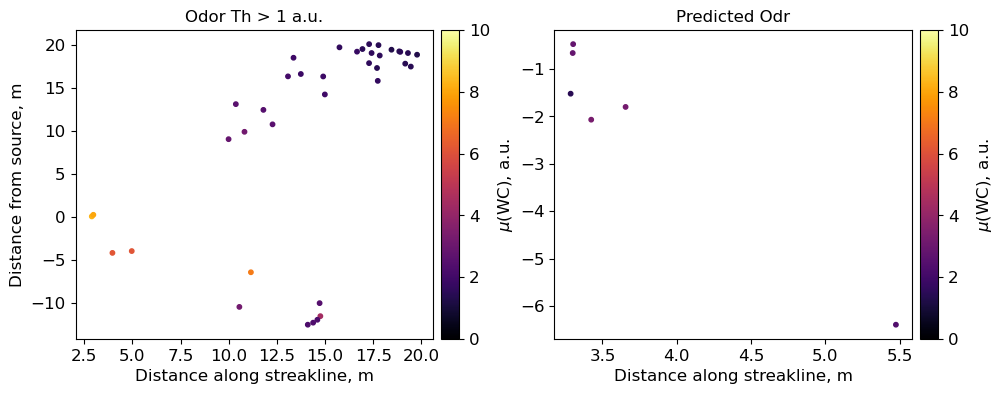

In [20]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=df.odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax1.set_title('Odor Th > 1 a.u.')
ax1.set_ylabel('Distance from source, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.predicted_odor, 
             s=10, cmap='inferno', vmin=0,vmax=10)

ax2.set_title('Predicted Odr')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

### Calculating Odor Statistics

In [55]:
test['scaled_odor']=osc.scale_data(test.odor)

In [67]:
osc.get_time_col(test,0.3)
# osc.calculate_distance_from_source(test)

In [57]:
def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    osc.mean_conc(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)

np.seterr(divide='ignore')
index = osc.get_index(test.odor,0.5)
index_predicted = osc.get_index(test.predicted_odor,0.5)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'mean_concentration'],
      dtype='object')

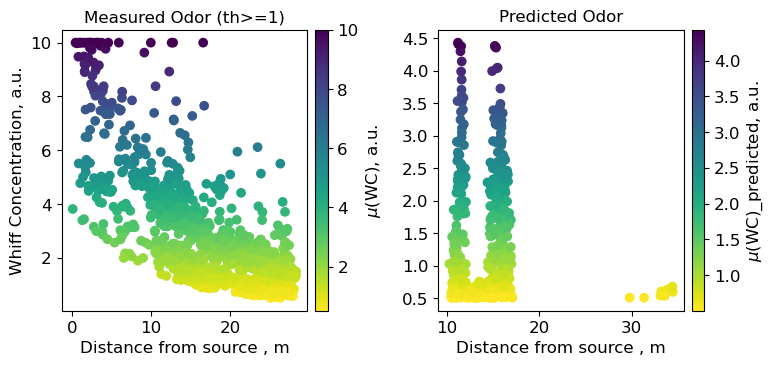

In [58]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('Whiff Concentration, a.u.')
ax1.set_xlabel('Distance from source , m')
ax1.set_title('Measured Odor (th>=1)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration_p, 
              c=fdf_predicted.mean_concentration_p, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")